# Integrantes:
- Elisa Parga
- Nicolás Fierro

En esta tarea vas a experimentar con diferentes funciones de activación y su rol en el aprendizaje de redes neuronales. Lo primero que haremos es importar los paquetes importantes para nuestro notebook e inicializar el gpu. Asegúrate que tu notebook se ejecuta sobre un GPU. Si es así, al ejecutar la siguiente celda debería salirte el mensaje "cuda".

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time
import numpy as np
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


A continuación hay un conjunto de funciones que puedes usar para hacer tus experimentos. Los detalles de cada función están como comentario antes del código de la función.

In [ ]:
#Esta función permite inicializar todas las semillas de números pseudoaleatorios.
# Puedes usar esta función para resetear los generadores de números aleatorios
def iniciar_semillas():
  SEED = 1234

  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

#Función para computar el accuracy. Se asume que predicciones y etiquetas son tensores en el GPU
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

#Función para entrenar una época de un modelo. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -optimizer: el optimizador para el entrenamiento
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def train_one_epoch(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation  
  model.train()
  
  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.long().to(device) #Labels
        
    optimizer.zero_grad() #Clean gradients
             
    y_pred = model(x) #Feed the network with data
        
    loss = criterion(y_pred, y) #Compute the loss
       
    acc = calculate_accuracy(y_pred, y) #Compute the accuracy
        
    loss.backward() #Compute gradients
        
    optimizer.step() #Apply update rules
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Función que evalúa una red neuronal con un conjunto de datos de prueba. Recibe como parámetros
#     -model: una red neuronal
#     -iterator: un iterador de la data a usar para el entrenamiento (generalmente creado con un DataLoader)
#     -criterion: la función de loss
#     -device: dispositivo a usar para el entrenamiento
#Devuelve el loss promedio y el accuracy promedio de la época (promedio de todos los batches)
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for 
  #training (dropout for instance)    
  model.eval()
    
  with torch.no_grad(): #disable the autograd engine (save computation and memory)
        
    for (x, y) in iterator:
      x = x.to(device)
      y = y.long().to(device)

      y_pred= model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

#Calcula el tiempo transcurrido entre dos timestamps
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#Esta función realiza el entrenamiento completo de una red. Recibe como parámetros:
#     -network: la red neuronal
#     -optimizer: el optimizador para entrenamiento
#     -train_loader: el dataloader de datos de entrenamiento
#     -test_loader: el dataloader de datos de prueba
#     -name: nombre a usar para guardar en disco la red con el mejor accuracy

def train_complete(network, optimizer, train_loader, test_loader, name):
  
  #Se envían la red y la función de loss al GPU
  network = network.to(device)
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.to(device)

  #Fijar el entrenamiento en 20 épocas siempre
  EPOCHS = 20

  best_valid_acc = float('-inf')

  for epoch in range(EPOCHS):
    
    start_time = time.time()

    #Train + validation cycles  
    train_loss, train_acc = train_one_epoch(network, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(network, test_loader, criterion, device)
    
    #Si encontramos un modelo con accuracy de validación mayor, lo guardamos
    if valid_acc > best_valid_acc:
     best_valid_acc = valid_acc
     torch.save(network.state_dict(), f'{name}.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  
  #Cuando se termina el entrenamiento, cargamos el mejor modelo guardado y calculamos el accuracy de prueba
  network.load_state_dict(torch.load(f'{name}.pt'))

  test_loss , test_acc = evaluate(network, test_loader, criterion, device)
  print(f'Test Loss: {test_loss:.3f} | Mejor test acc: {test_acc*100:.2f}%')

Para nuestros experimentos usaremos el dataset FashionMNIST, que consta de imágenes en escala de grises de 28x28 píxeles que representan prendas de ropa clasificadas en 10 clases. Inicializamos los hiperparámetros y cargamos los conjuntos de datos de entrenamiento y prueba. También se crean los dataloaders correspondientes.

In [ ]:
# Hyper-parameters 
input_size = 784
num_classes = 10
batch_size_train = 1000
batch_size_test = 1000
momentum = 0.9
log_interval = 100
learning_rate=0.01

# MNIST dataset 
train_dataset = torchvision.datasets.FashionMNIST(root='data', 
                    train=True, 
                    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]),  
                    download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='data', 
                                          train=False, 
                                          transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size_train, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size_test, 
                                          shuffle=False)

class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Inspeccionamos algunas muestras del conjunto de datos de prueba

Numero de batch: 0
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


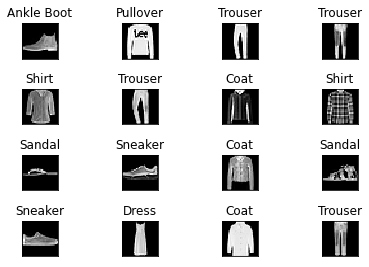

In [ ]:
examples = enumerate(test_loader) #Crea un iterador sobre la lista de batches

batchId, (exampleData, exampleTargets) = next(examples) #Obtenemos el siguiente batch
print('Numero de batch: {}'.format(batchId))
print(exampleData.shape)
print(exampleTargets.shape)

import matplotlib.pyplot as plt

#Mostramos los primeros 6 elementos del batch con su etiqueta
plt.figure()
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
  plt.title(class_names[exampleTargets[i]])
  plt.xticks([])
  plt.yticks([])

# Parte 1 - Creación de red neuronal
Crea una arquitectura de red neuronal (MLP - multilayer perceptron) que reciba datos de 784 dimensiones (recuerda que las imágenes del experimento son de 28x28 = 784 píxeles) y tenga 10 neuronas de salida. Para esta primera red usa la función sigmoide como función de activación en todas las capas ocultas y la función softmax en la capa de salida (recuerda que si usas nn.CrossEntropyLoss, no necesitas aplicar ninguna función adicional a la última capa de la red).

In [ ]:
#Creamos la red neuronal
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NetSigmoid_v1(nn.Module):
  def __init__(self):
    super(NetSigmoid_v1, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 250)
    self.layer2 = nn.Linear(250, 100)
    self.layer3 = nn.Linear(100, 10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.sigmoid(self.layer1(x))
    forward2 = F.sigmoid(self.layer2(forward1))
    
    y_pred = self.layer3(forward2)
    
    return y_pred

class NetSigmoid_v2(nn.Module):
  def __init__(self):
    super(NetSigmoid_v2, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 600)
    self.layer2 = nn.Linear(600, 500)
    self.layer3 = nn.Linear(500, 400)
    self.layer4 = nn.Linear(400, 300)
    self.layer5 = nn.Linear(300, 200)
    self.layer6 = nn.Linear(200, 100)
    self.layer7 = nn.Linear(100,10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.sigmoid(self.layer1(x))
    forward2 = F.sigmoid(self.layer2(forward1))
    forward3 = F.sigmoid(self.layer3(forward2))
    forward4 = F.sigmoid(self.layer4(forward3))
    forward5 = F.sigmoid(self.layer5(forward4))
    forward6 = F.sigmoid(self.layer6(forward5))
    
    y_pred = self.layer7(forward6)
        
    return y_pred

class NetSigmoid_v3(nn.Module):
  def __init__(self):
    super(NetSigmoid_v3, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 300)
    self.layer2 = nn.Linear(300, 10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.sigmoid(self.layer1(x))
        
    y_pred = self.layer2(forward1)
        
    return y_pred 


Para ejecutar el entrenamiento de tu primer modelo, ejecuta la siguiente celda y debería reportarte el accuracy de prueba de este primer experimento. Cuánto obtienes de accuracy de test?

In [ ]:
iniciar_semillas() # Se inicializan las semillas
network_v1 = NetSigmoid_v1() # Creas la red
optimizer = optim.Adam(network_v1.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network_v1, optimizer, train_loader, test_loader, 'sigmoid_v1') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 epocas)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 0.885 | Train Acc: 68.31%
	 Val. Loss: 0.506 |  Val. Acc: 81.44%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.431 | Train Acc: 84.59%
	 Val. Loss: 0.427 |  Val. Acc: 84.48%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.374 | Train Acc: 86.46%
	 Val. Loss: 0.408 |  Val. Acc: 85.17%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.343 | Train Acc: 87.63%
	 Val. Loss: 0.386 |  Val. Acc: 86.17%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.323 | Train Acc: 88.18%
	 Val. Loss: 0.380 |  Val. Acc: 86.54%
Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 0.313 | Train Acc: 88.57%
	 Val. Loss: 0.360 |  Val. Acc: 86.81%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.303 | Train Acc: 88.94%
	 Val. Loss: 0.369 |  Val. Acc: 86.52%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.291 | Train Acc: 89.34%
	 Val. Loss: 0.364 |  Val. Acc: 86.89%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.277 | Train Acc: 89.89%
	 Val. Loss: 0.367 |  Val. Acc: 86.66%
Epoch: 10 | Epoch T

In [ ]:
iniciar_semillas()
network_v2 = NetSigmoid_v2() # Creas la red
optimizer_v2 = optim.Adam(network_v2.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network_v2, optimizer_v2, train_loader, test_loader, 'sigmoid_v2') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 epocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 2.081 | Train Acc: 16.56%
	 Val. Loss: 1.597 |  Val. Acc: 28.73%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 1.431 | Train Acc: 36.91%
	 Val. Loss: 1.307 |  Val. Acc: 42.35%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 1.145 | Train Acc: 52.75%
	 Val. Loss: 0.970 |  Val. Acc: 61.51%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.955 | Train Acc: 60.16%
	 Val. Loss: 0.916 |  Val. Acc: 61.40%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.889 | Train Acc: 62.03%
	 Val. Loss: 1.122 |  Val. Acc: 52.31%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.852 | Train Acc: 62.58%
	 Val. Loss: 0.843 |  Val. Acc: 66.82%
Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 0.857 | Train Acc: 62.62%
	 Val. Loss: 0.837 |  Val. Acc: 63.38%
Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 0.787 | Train Acc: 67.79%
	 Val. Loss: 0.758 |  Val. Acc: 72.38%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.708 | Train Acc: 72.57%
	 Val. Loss: 0.683 |  Val. Acc: 73.23%
Epoch: 10 | Epoch T

In [ ]:
iniciar_semillas()
network_v3 = NetSigmoid_v3() # Creas la red
optimizer_v3 = optim.Adam(network_v3.parameters(), lr=learning_rate) #Creas el optimizador
train_complete(network_v3, optimizer_v3, train_loader, test_loader, 'sigmoid_v3') #Entrenas la red. IMPORTANTE: el número de épocas siempre debe ser el mismo (internamente son 20 epocas)

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.711 | Train Acc: 74.00%
	 Val. Loss: 0.478 |  Val. Acc: 82.29%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.411 | Train Acc: 85.18%
	 Val. Loss: 0.427 |  Val. Acc: 84.89%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.358 | Train Acc: 87.10%
	 Val. Loss: 0.405 |  Val. Acc: 85.49%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.335 | Train Acc: 87.89%
	 Val. Loss: 0.369 |  Val. Acc: 86.76%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.315 | Train Acc: 88.66%
	 Val. Loss: 0.359 |  Val. Acc: 87.36%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.296 | Train Acc: 89.24%
	 Val. Loss: 0.361 |  Val. Acc: 87.28%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.282 | Train Acc: 89.67%
	 Val. Loss: 0.350 |  Val. Acc: 87.60%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.276 | Train Acc: 89.86%
	 Val. Loss: 0.353 |  Val. Acc: 87.06%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.265 | Train Acc: 90.17%
	 Val. Loss: 0.342 |  Val. Acc: 87.73%
Epoch: 10 | Epoch T

En esta primera experiencia se probaron tres redes neuronales con arquitecturas diferentes y con la función sigmoid como función de activación en las capas ocultas. Las arquitecturas fueron las siguientes (número de neuronas por capa):

*   Versión 1: 784 - 250 - 100 - 10
*   Versión 2:  784 - 600 - 500 - 400 - 300 - 200 - 100 - 10
*   Versión 3: 784 - 300 - 10

La decisión detrás de estas elecciones de número de capas y número de neuronas viene dada por el deseo de observar los efectos de las funciones de activación y sus potenciales para propagar errores en redes con muchas y pocas capas.
Los resultados luego de entrenarlas con Adam optimizer y 20 épocas se resumen en la siguiente tabla:

\begin{array}{|c|c|c|c|}
  \hline
  \text{} & \text{Versión 1} & \text{Versión 2} & \text{Versión 3} \\
  \hline
  \text{Loss} & 0.346 & 0.545 & 0.338 \\
  \hline
  \text{Test Accuracy} & 88.16\% & 81.94\% & 88.01\% \\
  \hline
\end{array}

Podemos remarcar que la versión 1 y 3 dan resultados similares mientras que la versión 2 es un poco menos precisa al evaluar sobre el dataset de test y presenta una loss ligeramente mayor. Esto es relativamente esperable de una red que usa solamente sigmoid como función de activación, pues esta tiene tendencia a no propagar mucho los errores al momento de realizar la optimización.

# Parte 2
En esta parte vas a comparar el accuracy de test de la primera red que creaste (con función de activación sigmoide) y los accuracys obtenidos usando otras funciones de activación. Para lograr esto debes hacer lo siguiente:



*   Implementa exactamente la misma arquitectura que tu primera red, pero ahora vas a usar las siguientes funciones de activación: Leaky Relu, Mish, Elu y Silu. Implementa una clase por cada función de activación, en donde la red neuronal use la misma función de activación en las capas ocultas. Asegúrate que la arquitectura es la misma y que lo único que cambia entre las distintas redes es la función de activación de las capas ocultas.
*   Entrena cada red usando la función "train_complete" usando el mismo optimizador siempre. 
*   Registra los mejores accuracys de test de cada red neuronal.
*   Discute los resultados ontenidos. Puedes tratar de responder a estas preguntas:
    * Qué función de activación dio el mejor accuracy de test?
    * Porqué crees que, ante las mismas condiciones, hay funciones de activación que funcionan mejor que otras?
    * Averigua cómo funcionan cada una de las funciones de activación usadas en la tarea. Es posible hacer algún razonamiento sobre el comportamiento de cada función y que eso permita explicar los resultados de tu tarea?

### Leaky:

In [ ]:
class NetLeaky_v1(nn.Module):

  def __init__(self):
    super(NetLeaky_v1, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 250)
    self.layer2 = nn.Linear(250, 100)
    self.layer3 = nn.Linear(100, 10)

  #Forward: what happens when we feed the network with data
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    forward1 = F.leaky_relu(self.layer1(x))
    forward2 = F.leaky_relu(self.layer2(forward1))
    y_pred = self.layer3(forward2)

    #Our network returns the output of the final layer but also the output of the hidden layer
    return y_pred

class NetLeaky_v2(nn.Module):

  def __init__(self):
    super(NetLeaky_v2, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 600)
    self.layer2 = nn.Linear(600, 500)
    self.layer3 = nn.Linear(500, 400)
    self.layer4 = nn.Linear(400, 300)
    self.layer5 = nn.Linear(300, 200)
    self.layer6 = nn.Linear(200, 100)
    self.layer7 = nn.Linear(100,10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.leaky_relu(self.layer1(x))
    forward2 = F.leaky_relu(self.layer2(forward1))
    forward3 = F.leaky_relu(self.layer3(forward2))
    forward4 = F.leaky_relu(self.layer4(forward3))
    forward5 = F.leaky_relu(self.layer5(forward4))
    forward6 = F.leaky_relu(self.layer6(forward5))
    
    y_pred = self.layer7(forward6)
        
    return y_pred

class NetLeaky_v3(nn.Module):
  def __init__(self):
    super(NetLeaky_v3, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 300)
    self.layer2 = nn.Linear(300, 10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.leaky_relu(self.layer1(x))
        
    y_pred = self.layer2(forward1)
        
    return y_pred 


In [ ]:
iniciar_semillas() 
network_leaky_v1 = NetLeaky_v1()
optimizer_leaky_v1 = optim.Adam(network_leaky_v1.parameters(), lr=learning_rate)
train_complete(network_leaky_v1, optimizer_leaky_v1, train_loader, test_loader, 'leaky_v1')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.808 | Train Acc: 72.38%
	 Val. Loss: 0.457 |  Val. Acc: 83.45%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.404 | Train Acc: 85.17%
	 Val. Loss: 0.409 |  Val. Acc: 85.09%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.351 | Train Acc: 87.02%
	 Val. Loss: 0.384 |  Val. Acc: 86.31%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.323 | Train Acc: 88.01%
	 Val. Loss: 0.378 |  Val. Acc: 86.36%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.308 | Train Acc: 88.57%
	 Val. Loss: 0.380 |  Val. Acc: 86.17%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.304 | Train Acc: 88.66%
	 Val. Loss: 0.366 |  Val. Acc: 86.92%
Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 0.282 | Train Acc: 89.42%
	 Val. Loss: 0.364 |  Val. Acc: 86.71%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.273 | Train Acc: 89.74%
	 Val. Loss: 0.362 |  Val. Acc: 86.79%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.264 | Train Acc: 90.11%
	 Val. Loss: 0.377 |  Val. Acc: 86.50%
Epoch: 10 | Epoch T

In [ ]:
iniciar_semillas() 
network_leaky_v2 = NetLeaky_v2()
optimizer_leaky_v2 = optim.Adam(network_leaky_v2.parameters(), lr=learning_rate)
train_complete(network_leaky_v2, optimizer_leaky_v2, train_loader, test_loader, 'leaky_v2')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.303 | Train Acc: 49.82%
	 Val. Loss: 0.672 |  Val. Acc: 73.38%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.532 | Train Acc: 80.26%
	 Val. Loss: 0.478 |  Val. Acc: 82.60%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.419 | Train Acc: 84.68%
	 Val. Loss: 0.437 |  Val. Acc: 84.05%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.377 | Train Acc: 86.17%
	 Val. Loss: 0.397 |  Val. Acc: 85.85%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.350 | Train Acc: 87.08%
	 Val. Loss: 0.406 |  Val. Acc: 85.80%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.334 | Train Acc: 87.82%
	 Val. Loss: 0.409 |  Val. Acc: 85.51%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.323 | Train Acc: 88.18%
	 Val. Loss: 0.400 |  Val. Acc: 86.07%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.301 | Train Acc: 89.00%
	 Val. Loss: 0.377 |  Val. Acc: 86.55%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.296 | Train Acc: 89.13%
	 Val. Loss: 0.379 |  Val. Acc: 87.20%
Epoch: 10 | Epoch T

In [ ]:
iniciar_semillas() 
network_leaky_v3 = NetLeaky_v3()
optimizer_leaky_v3 = optim.Adam(network_leaky_v3.parameters(), lr=learning_rate)
train_complete(network_leaky_v3, optimizer_leaky_v3, train_loader, test_loader, 'leaky_v3')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.826 | Train Acc: 73.71%
	 Val. Loss: 0.481 |  Val. Acc: 82.32%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.413 | Train Acc: 85.07%
	 Val. Loss: 0.417 |  Val. Acc: 84.95%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.355 | Train Acc: 87.13%
	 Val. Loss: 0.422 |  Val. Acc: 85.27%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.335 | Train Acc: 87.93%
	 Val. Loss: 0.374 |  Val. Acc: 86.42%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.312 | Train Acc: 88.60%
	 Val. Loss: 0.386 |  Val. Acc: 86.61%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.294 | Train Acc: 89.10%
	 Val. Loss: 0.384 |  Val. Acc: 86.61%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.294 | Train Acc: 89.15%
	 Val. Loss: 0.375 |  Val. Acc: 86.86%
Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 0.272 | Train Acc: 90.01%
	 Val. Loss: 0.364 |  Val. Acc: 87.16%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.262 | Train Acc: 90.24%
	 Val. Loss: 0.372 |  Val. Acc: 87.12%
Epoch: 10 | Epoch T

### ReLu:

In [ ]:
class NetReLu_v1(nn.Module):

  def __init__(self):
    super(NetReLu_v1, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 250)
    self.layer2 = nn.Linear(250, 100)
    self.layer3 = nn.Linear(100, 10)

  #Forward: what happens when we feed the network with data
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    forward1 = F.relu(self.layer1(x))
    forward2 = F.relu(self.layer2(forward1))
    y_pred = self.layer3(forward2)

    #Our network returns the output of the final layer but also the output of the hidden layer
    return y_pred

class NetReLu_v2(nn.Module):

  def __init__(self):
    super(NetReLu_v2, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 600)
    self.layer2 = nn.Linear(600, 500)
    self.layer3 = nn.Linear(500, 400)
    self.layer4 = nn.Linear(400, 300)
    self.layer5 = nn.Linear(300, 200)
    self.layer6 = nn.Linear(200, 100)
    self.layer7 = nn.Linear(100,10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.relu(self.layer1(x))
    forward2 = F.relu(self.layer2(forward1))
    forward3 = F.relu(self.layer3(forward2))
    forward4 = F.relu(self.layer4(forward3))
    forward5 = F.relu(self.layer5(forward4))
    forward6 = F.relu(self.layer6(forward5))
    
    y_pred = self.layer7(forward6)
        
    return y_pred

class NetReLu_v3(nn.Module):
  def __init__(self):
    super(NetReLu_v3, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 300)
    self.layer2 = nn.Linear(300, 10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.relu(self.layer1(x))
        
    y_pred = self.layer2(forward1)
        
    return y_pred 

In [ ]:
iniciar_semillas() 
network_relu_v1 = NetReLu_v1()
optimizer_relu_v1 = optim.Adam(network_relu_v1.parameters(), lr=learning_rate)
train_complete(network_relu_v1, optimizer_relu_v1, train_loader, test_loader, 'relu_v1')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.803 | Train Acc: 72.37%
	 Val. Loss: 0.462 |  Val. Acc: 83.27%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.403 | Train Acc: 85.16%
	 Val. Loss: 0.419 |  Val. Acc: 84.89%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.354 | Train Acc: 86.92%
	 Val. Loss: 0.398 |  Val. Acc: 85.59%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.326 | Train Acc: 88.00%
	 Val. Loss: 0.379 |  Val. Acc: 86.63%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.307 | Train Acc: 88.57%
	 Val. Loss: 0.362 |  Val. Acc: 87.24%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.295 | Train Acc: 88.99%
	 Val. Loss: 0.371 |  Val. Acc: 86.57%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.284 | Train Acc: 89.35%
	 Val. Loss: 0.382 |  Val. Acc: 86.03%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.280 | Train Acc: 89.54%
	 Val. Loss: 0.369 |  Val. Acc: 86.86%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.265 | Train Acc: 90.13%
	 Val. Loss: 0.372 |  Val. Acc: 87.17%
Epoch: 10 | Epoch T

In [ ]:
iniciar_semillas() 
network_relu_v2 = NetReLu_v2()
optimizer_relu_v2 = optim.Adam(network_relu_v2.parameters(), lr=learning_rate)
train_complete(network_relu_v2, optimizer_relu_v2, train_loader, test_loader, 'relu_v2')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.191 | Train Acc: 51.63%
	 Val. Loss: 0.642 |  Val. Acc: 74.77%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.504 | Train Acc: 81.35%
	 Val. Loss: 0.478 |  Val. Acc: 82.82%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.417 | Train Acc: 84.79%
	 Val. Loss: 0.434 |  Val. Acc: 84.22%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.394 | Train Acc: 85.73%
	 Val. Loss: 0.413 |  Val. Acc: 85.18%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.350 | Train Acc: 87.22%
	 Val. Loss: 0.415 |  Val. Acc: 85.15%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.348 | Train Acc: 87.31%
	 Val. Loss: 0.405 |  Val. Acc: 85.77%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.324 | Train Acc: 88.24%
	 Val. Loss: 0.389 |  Val. Acc: 86.03%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.311 | Train Acc: 88.52%
	 Val. Loss: 0.378 |  Val. Acc: 86.18%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.298 | Train Acc: 89.03%
	 Val. Loss: 0.379 |  Val. Acc: 86.84%
Epoch: 10 | Epoch T

In [ ]:
iniciar_semillas() 
network_relu_v3 = NetReLu_v3()
optimizer_relu_v3 = optim.Adam(network_relu_v3.parameters(), lr=learning_rate)
train_complete(network_relu_v3, optimizer_relu_v3, train_loader, test_loader, 'relu_v3')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.833 | Train Acc: 73.37%
	 Val. Loss: 0.490 |  Val. Acc: 81.83%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.418 | Train Acc: 84.82%
	 Val. Loss: 0.425 |  Val. Acc: 84.78%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.359 | Train Acc: 86.96%
	 Val. Loss: 0.407 |  Val. Acc: 85.55%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.337 | Train Acc: 87.76%
	 Val. Loss: 0.395 |  Val. Acc: 85.49%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.314 | Train Acc: 88.53%
	 Val. Loss: 0.390 |  Val. Acc: 86.30%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.298 | Train Acc: 88.97%
	 Val. Loss: 0.374 |  Val. Acc: 87.01%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.295 | Train Acc: 89.13%
	 Val. Loss: 0.378 |  Val. Acc: 86.83%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.279 | Train Acc: 89.78%
	 Val. Loss: 0.385 |  Val. Acc: 86.50%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.268 | Train Acc: 90.00%
	 Val. Loss: 0.362 |  Val. Acc: 87.53%
Epoch: 10 | Epoch T

### Mish:

In [ ]:
class NetMish_v1(nn.Module):

  def __init__(self):
    super(NetMish_v1, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 250)
    self.layer2 = nn.Linear(250, 100)
    self.layer3 = nn.Linear(100, 10)

  #Forward: what happens when we feed the network with data
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    forward1 = F.mish(self.layer1(x))
    forward2 = F.mish(self.layer2(forward1))
    y_pred = self.layer3(forward2)

    #Our network returns the output of the final layer but also the output of the hidden layer
    return y_pred

class NetMish_v2(nn.Module):

  def __init__(self):
    super(NetMish_v2, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 600)
    self.layer2 = nn.Linear(600, 500)
    self.layer3 = nn.Linear(500, 400)
    self.layer4 = nn.Linear(400, 300)
    self.layer5 = nn.Linear(300, 200)
    self.layer6 = nn.Linear(200, 100)
    self.layer7 = nn.Linear(100,10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.mish(self.layer1(x))
    forward2 = F.mish(self.layer2(forward1))
    forward3 = F.mish(self.layer3(forward2))
    forward4 = F.mish(self.layer4(forward3))
    forward5 = F.mish(self.layer5(forward4))
    forward6 = F.mish(self.layer6(forward5))
    
    y_pred = self.layer7(forward6)
        
    return y_pred

class NetMish_v3(nn.Module):
  def __init__(self):
    super(NetMish_v3, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 300)
    self.layer2 = nn.Linear(300, 10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.mish(self.layer1(x))
        
    y_pred = self.layer2(forward1)
        
    return y_pred 

In [ ]:
iniciar_semillas() 
network_mish_v1 = NetMish_v1()
optimizer_mish_v1 = optim.Adam(network_mish_v1.parameters(), lr=learning_rate)
train_complete(network_mish_v1, optimizer_mish_v1, train_loader, test_loader, 'mish_v1')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.746 | Train Acc: 73.04%
	 Val. Loss: 0.452 |  Val. Acc: 83.55%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.398 | Train Acc: 85.38%
	 Val. Loss: 0.406 |  Val. Acc: 85.33%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.348 | Train Acc: 87.18%
	 Val. Loss: 0.375 |  Val. Acc: 86.28%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.320 | Train Acc: 88.21%
	 Val. Loss: 0.392 |  Val. Acc: 86.11%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.306 | Train Acc: 88.61%
	 Val. Loss: 0.362 |  Val. Acc: 87.06%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.292 | Train Acc: 89.12%
	 Val. Loss: 0.368 |  Val. Acc: 86.93%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.282 | Train Acc: 89.41%
	 Val. Loss: 0.382 |  Val. Acc: 86.08%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.272 | Train Acc: 89.84%
	 Val. Loss: 0.374 |  Val. Acc: 86.93%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.258 | Train Acc: 90.40%
	 Val. Loss: 0.358 |  Val. Acc: 87.55%
Epoch: 10 | Epoch T

In [ ]:
iniciar_semillas() 
network_mish_v2 = NetMish_v2()
optimizer_mish_v2 = optim.Adam(network_mish_v2.parameters(), lr=learning_rate)
train_complete(network_mish_v2, optimizer_mish_v2, train_loader, test_loader, 'mish_v2')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 2.441 | Train Acc: 48.97%
	 Val. Loss: 0.726 |  Val. Acc: 71.74%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.556 | Train Acc: 79.13%
	 Val. Loss: 0.505 |  Val. Acc: 81.41%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.445 | Train Acc: 83.64%
	 Val. Loss: 0.455 |  Val. Acc: 83.85%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.410 | Train Acc: 85.11%
	 Val. Loss: 0.435 |  Val. Acc: 84.69%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.366 | Train Acc: 86.69%
	 Val. Loss: 0.408 |  Val. Acc: 85.17%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.351 | Train Acc: 87.20%
	 Val. Loss: 0.397 |  Val. Acc: 85.81%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.338 | Train Acc: 87.62%
	 Val. Loss: 0.379 |  Val. Acc: 86.39%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.325 | Train Acc: 88.08%
	 Val. Loss: 0.384 |  Val. Acc: 86.56%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.301 | Train Acc: 88.74%
	 Val. Loss: 0.368 |  Val. Acc: 86.95%
Epoch: 10 | Epoch T

In [ ]:
iniciar_semillas() 
network_mish_v3 = NetMish_v3()
optimizer_mish_v3 = optim.Adam(network_mish_v3.parameters(), lr=learning_rate)
train_complete(network_mish_v3, optimizer_mish_v3, train_loader, test_loader, 'mish_v3')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.776 | Train Acc: 74.77%
	 Val. Loss: 0.461 |  Val. Acc: 83.56%
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.407 | Train Acc: 85.32%
	 Val. Loss: 0.418 |  Val. Acc: 84.95%
Epoch: 03 | Epoch Time: 0m 12s
	Train Loss: 0.356 | Train Acc: 87.04%
	 Val. Loss: 0.417 |  Val. Acc: 85.31%
Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 0.327 | Train Acc: 87.99%
	 Val. Loss: 0.397 |  Val. Acc: 85.19%
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 0.305 | Train Acc: 88.67%
	 Val. Loss: 0.376 |  Val. Acc: 86.95%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.293 | Train Acc: 89.12%
	 Val. Loss: 0.367 |  Val. Acc: 86.97%
Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 0.283 | Train Acc: 89.55%
	 Val. Loss: 0.356 |  Val. Acc: 87.51%
Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 0.266 | Train Acc: 90.09%
	 Val. Loss: 0.358 |  Val. Acc: 87.55%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.258 | Train Acc: 90.37%
	 Val. Loss: 0.366 |  Val. Acc: 87.49%
Epoch: 10 | Epoch T

In [ ]:
class NetELu_v1(nn.Module):

  def __init__(self):
    super(NetELu_v1, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 250)
    self.layer2 = nn.Linear(250, 100)
    self.layer3 = nn.Linear(100, 10)

  #Forward: what happens when we feed the network with data
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    forward1 = F.elu(self.layer1(x))
    forward2 = F.elu(self.layer2(forward1))
    y_pred = self.layer3(forward2)

    #Our network returns the output of the final layer but also the output of the hidden layer
    return y_pred

class NetELu_v2(nn.Module):

  def __init__(self):
    super(NetELu_v2, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 600)
    self.layer2 = nn.Linear(600, 500)
    self.layer3 = nn.Linear(500, 400)
    self.layer4 = nn.Linear(400, 300)
    self.layer5 = nn.Linear(300, 200)
    self.layer6 = nn.Linear(200, 100)
    self.layer7 = nn.Linear(100,10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.elu(self.layer1(x))
    forward2 = F.elu(self.layer2(forward1))
    forward3 = F.elu(self.layer3(forward2))
    forward4 = F.elu(self.layer4(forward3))
    forward5 = F.elu(self.layer5(forward4))
    forward6 = F.elu(self.layer6(forward5))
    
    y_pred = self.layer7(forward6)
        
    return y_pred

class NetELu_v3(nn.Module):
  def __init__(self):
    super(NetELu_v3, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 300)
    self.layer2 = nn.Linear(300, 10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.elu(self.layer1(x))
        
    y_pred = self.layer2(forward1)
        
    return y_pred 

In [ ]:
iniciar_semillas() 
network_elu_v1 = NetELu_v1()
optimizer_elu_v1 = optim.Adam(network_elu_v1.parameters(), lr=learning_rate)
train_complete(network_elu_v1, optimizer_elu_v1, train_loader, test_loader, 'elu_v1')

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.834 | Train Acc: 71.29%
	 Val. Loss: 0.463 |  Val. Acc: 82.96%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.403 | Train Acc: 85.21%
	 Val. Loss: 0.402 |  Val. Acc: 85.50%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.356 | Train Acc: 86.89%
	 Val. Loss: 0.409 |  Val. Acc: 84.42%
Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 0.331 | Train Acc: 87.62%
	 Val. Loss: 0.378 |  Val. Acc: 86.43%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.314 | Train Acc: 88.37%
	 Val. Loss: 0.360 |  Val. Acc: 87.41%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.300 | Train Acc: 88.92%
	 Val. Loss: 0.368 |  Val. Acc: 86.70%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.285 | Train Acc: 89.31%
	 Val. Loss: 0.375 |  Val. Acc: 86.01%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.271 | Train Acc: 89.83%
	 Val. Loss: 0.344 |  Val. Acc: 87.54%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.253 | Train Acc: 90.48%
	 Val. Loss: 0.390 |  Val. Acc: 86.63%
Epoch: 10 | Epoch Tim

In [ ]:
iniciar_semillas() 
network_elu_v2 = NetELu_v2()
optimizer_elu_v2 = optim.Adam(network_elu_v2.parameters(), lr=learning_rate)
train_complete(network_elu_v2, optimizer_elu_v2, train_loader, test_loader, 'elu_v2')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.868 | Train Acc: 44.31%
	 Val. Loss: 0.773 |  Val. Acc: 68.61%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.668 | Train Acc: 74.24%
	 Val. Loss: 0.561 |  Val. Acc: 78.55%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.519 | Train Acc: 80.08%
	 Val. Loss: 0.522 |  Val. Acc: 80.35%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.479 | Train Acc: 82.15%
	 Val. Loss: 0.461 |  Val. Acc: 83.75%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.412 | Train Acc: 85.12%
	 Val. Loss: 0.422 |  Val. Acc: 85.14%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.389 | Train Acc: 86.00%
	 Val. Loss: 0.409 |  Val. Acc: 85.84%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.347 | Train Acc: 87.39%
	 Val. Loss: 0.447 |  Val. Acc: 84.69%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.330 | Train Acc: 87.90%
	 Val. Loss: 0.383 |  Val. Acc: 85.92%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.310 | Train Acc: 88.52%
	 Val. Loss: 0.363 |  Val. Acc: 86.90%
Epoch: 10 | Epoch T

In [ ]:
iniciar_semillas() 
network_elu_v3 = NetELu_v3()
optimizer_elu_v3 = optim.Adam(network_elu_v3.parameters(), lr=learning_rate)
train_complete(network_elu_v3, optimizer_elu_v3, train_loader, test_loader, 'elu_v3')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.818 | Train Acc: 74.02%
	 Val. Loss: 0.477 |  Val. Acc: 82.79%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.427 | Train Acc: 84.49%
	 Val. Loss: 0.434 |  Val. Acc: 84.80%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.360 | Train Acc: 86.90%
	 Val. Loss: 0.400 |  Val. Acc: 85.74%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.343 | Train Acc: 87.43%
	 Val. Loss: 0.378 |  Val. Acc: 86.37%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.322 | Train Acc: 88.25%
	 Val. Loss: 0.383 |  Val. Acc: 86.53%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 0.308 | Train Acc: 88.71%
	 Val. Loss: 0.389 |  Val. Acc: 86.40%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 0.297 | Train Acc: 89.14%
	 Val. Loss: 0.370 |  Val. Acc: 86.97%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.271 | Train Acc: 90.02%
	 Val. Loss: 0.363 |  Val. Acc: 87.46%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.266 | Train Acc: 90.11%
	 Val. Loss: 0.360 |  Val. Acc: 87.59%
Epoch: 10 | Epoch Tim

In [ ]:
class NetSiLu_v1(nn.Module):

  def __init__(self):
    super(NetSiLu_v1, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 250)
    self.layer2 = nn.Linear(250, 100)
    self.layer3 = nn.Linear(100, 10)

  #Forward: what happens when we feed the network with data
  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    forward1 = F.silu(self.layer1(x))
    forward2 = F.silu(self.layer2(forward1))
    y_pred = self.layer3(forward2)

    #Our network returns the output of the final layer but also the output of the hidden layer
    return y_pred

class NetSiLu_v2(nn.Module):

  def __init__(self):
    super(NetSiLu_v2, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 600)
    self.layer2 = nn.Linear(600, 500)
    self.layer3 = nn.Linear(500, 400)
    self.layer4 = nn.Linear(400, 300)
    self.layer5 = nn.Linear(300, 200)
    self.layer6 = nn.Linear(200, 100)
    self.layer7 = nn.Linear(100,10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.silu(self.layer1(x))
    forward2 = F.silu(self.layer2(forward1))
    forward3 = F.silu(self.layer3(forward2))
    forward4 = F.silu(self.layer4(forward3))
    forward5 = F.silu(self.layer5(forward4))
    forward6 = F.silu(self.layer6(forward5))
    
    y_pred = self.layer7(forward6)
        
    return y_pred

class NetSiLu_v3(nn.Module):
  def __init__(self):
    super(NetSiLu_v3, self).__init__()
    # Define aquí las capas de tu red
    self.layer1 = nn.Linear(784, 300)
    self.layer2 = nn.Linear(300, 10)
    
  def forward(self, x):
    batch_size = x.shape[0] # obtenemos el tamaño del mini-batch, en este caso es 1000
    x = x.view(batch_size, -1) # pasamos cada imagen de entrada (28x28) a un gran array de dimensión 784
    forward1 = F.silu(self.layer1(x))
        
    y_pred = self.layer2(forward1)
        
    return y_pred 

In [ ]:
iniciar_semillas() 
network_silu_v1 = NetSiLu_v1()
optimizer_silu_v1 = optim.Adam(network_silu_v1.parameters(), lr=learning_rate)
train_complete(network_silu_v1, optimizer_silu_v1, train_loader, test_loader, 'silu_v1')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.736 | Train Acc: 73.19%
	 Val. Loss: 0.451 |  Val. Acc: 83.41%
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.393 | Train Acc: 85.45%
	 Val. Loss: 0.388 |  Val. Acc: 86.11%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.349 | Train Acc: 87.03%
	 Val. Loss: 0.388 |  Val. Acc: 85.89%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.314 | Train Acc: 88.23%
	 Val. Loss: 0.369 |  Val. Acc: 86.86%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.299 | Train Acc: 88.79%
	 Val. Loss: 0.357 |  Val. Acc: 86.89%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.288 | Train Acc: 89.17%
	 Val. Loss: 0.352 |  Val. Acc: 87.54%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.272 | Train Acc: 89.79%
	 Val. Loss: 0.392 |  Val. Acc: 86.00%
Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 0.269 | Train Acc: 89.93%
	 Val. Loss: 0.347 |  Val. Acc: 87.24%
Epoch: 09 | Epoch Time: 0m 9s
	Train Loss: 0.251 | Train Acc: 90.56%
	 Val. Loss: 0.365 |  Val. Acc: 87.43%
Epoch: 10 | Epoch Time: 

In [ ]:
iniciar_semillas() 
network_silu_v2 = NetSiLu_v2()
optimizer_silu_v2 = optim.Adam(network_silu_v2.parameters(), lr=learning_rate)
train_complete(network_silu_v2, optimizer_silu_v2, train_loader, test_loader, 'silu_v2')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.625 | Train Acc: 45.30%
	 Val. Loss: 0.787 |  Val. Acc: 68.98%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.597 | Train Acc: 77.65%
	 Val. Loss: 0.518 |  Val. Acc: 80.87%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.456 | Train Acc: 83.32%
	 Val. Loss: 0.482 |  Val. Acc: 82.67%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.410 | Train Acc: 85.13%
	 Val. Loss: 0.440 |  Val. Acc: 84.52%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.371 | Train Acc: 86.56%
	 Val. Loss: 0.408 |  Val. Acc: 85.66%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.355 | Train Acc: 87.03%
	 Val. Loss: 0.399 |  Val. Acc: 85.64%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.325 | Train Acc: 88.24%
	 Val. Loss: 0.383 |  Val. Acc: 87.01%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.299 | Train Acc: 88.97%
	 Val. Loss: 0.353 |  Val. Acc: 87.54%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.287 | Train Acc: 89.43%
	 Val. Loss: 0.388 |  Val. Acc: 86.23%
Epoch: 10 | Epoch T

In [ ]:
iniciar_semillas() 
network_silu_v3 = NetSiLu_v3()
optimizer_silu_v3 = optim.Adam(network_silu_v3.parameters(), lr=learning_rate)
train_complete(network_silu_v3, optimizer_silu_v3, train_loader, test_loader, 'silu_v3')

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.821 | Train Acc: 73.59%
	 Val. Loss: 0.485 |  Val. Acc: 82.44%
Epoch: 02 | Epoch Time: 0m 13s
	Train Loss: 0.415 | Train Acc: 84.98%
	 Val. Loss: 0.416 |  Val. Acc: 85.13%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.355 | Train Acc: 87.09%
	 Val. Loss: 0.407 |  Val. Acc: 85.41%
Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 0.331 | Train Acc: 87.86%
	 Val. Loss: 0.370 |  Val. Acc: 86.61%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 0.310 | Train Acc: 88.61%
	 Val. Loss: 0.378 |  Val. Acc: 86.98%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.300 | Train Acc: 88.90%
	 Val. Loss: 0.376 |  Val. Acc: 86.76%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.290 | Train Acc: 89.25%
	 Val. Loss: 0.367 |  Val. Acc: 87.28%
Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 0.269 | Train Acc: 90.06%
	 Val. Loss: 0.376 |  Val. Acc: 86.90%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.258 | Train Acc: 90.41%
	 Val. Loss: 0.356 |  Val. Acc: 87.88%
Epoch: 10 | Epoch T

Dado los resultados de las arquitecturas de redes neuronales experimentadas en la parte 1, inicialmente se probó ver el resultado de aplicar diferentes funciones de activación a las capas ocultas de la red más precisa, es decir, nuestra versión 1, sin cambiar los otros tipos de parámetros.

Una vez se había entrenado la red neuronal con las 5 funciones de activación diferentes (Leaky, ReLu, Mish, ELu y SiLu), se observó que se obtenían resultados similares: al rededor de 0.355 para la loss y 88% para la test accuracy. Al no encontrar mayor diferencia con los resultados obtenidos en un primer momento (con la función sigmoide), se decidió entrenar las otras dos arquitecturas, prestando particular atención a la versión 2 que tenía mayor loss y menor test accuracy. Los resultados fueron los siguientes:

* **Test Accuracy**:

\begin{array}{|c|c|c|c|c|c|}
  \hline
  \text{} & \text{Leaky} & \text{ReLu} & \text{Mish} & \text{ELu} & \text{SiLu}\\
  \hline
  \text{Versión 1} & 88.35\% & 88.06\% & 88.11\% & 88.54\% & 88.39\% \\
  \hline
  \text{Versión 2} & 88.39\% & 87.72\% & 87.98\% & 88.58\% & 88.33\% \\
  \hline
  \text{Versión 3} & 87.86\% & 88.21\% & 88.11\% & 88.58\% & 88.19\% \\
  \hline 
\end{array}

* **Loss**:

\begin{array}{|c|c|c|c|c|c|}
  \hline
  \text{} & \text{Leaky} & \text{ReLu} & \text{Mish} & \text{ELu} & \text{SiLu}\\
  \hline
  \text{Versión 1} & 0.365 & 0.349 & 0.375 & 0.378 & 0.356 \\
  \hline
  \text{Versión 2} & 0.370 & 0.373 & 0.343 & 0.347 & 0.354 \\
  \hline
  \text{Versión 3} & 0.381 & 0.363 & 0.393 & 0.364 & 0.373 \\
  \hline 
\end{array}

Para poder comprender de forma correcta los resultados, es importante revisar cada una de las funciones de activación:

* **ReLu**: función lineal a trozos que dará salida a la entrada directamente si es positiva, de lo contrario, dará salida a cero.

\begin{equation}
y = max(0, x)
\end{equation}

* **Leaky ReLu**: muy similar a ReLu pero la salida de valores negativos es pequeña y negativa también, pero distinta de cero.

\begin{equation}
y = max(0.1x, x)
\end{equation}

* **Mish**: esta función no es monótona y es suave. Para valores positivos de inputs, el output es muy similar al de la función ReLu. Genera valores muy cercanos a cero como output de valores negativos.

\begin{equation}
y = x tanh(ln(1+e^{x}))
\end{equation}

* **ELu**: similar a ReLu y Leaky ReLu, pero más suave. También genera valores de salida negativos para inputs negativos.

\begin{equation}
y = \begin{cases}
      \alpha (e^{x}-1) & x < 0\\
      x \text{ si } & x \geq 0
    \end{cases}\
\end{equation}

* **SiLu**: esta función no es monótona. Tiene un mínimo global donde la derivada es cero que sirve como un "regularizador" implícito que inhibe el aprendizaje de pesos de grandes magnitudes.

\begin{equation}
y = x \frac{1}{1+e^{-x}}
\end{equation}


Para poder realizar un análisis mejor de cada función de activación es pertinente mirar una arquitectura de red a la vez:

#### **Versión 1**: 
Para esta red, las funciones de activación que permitieron una mayor test accuracy fueron ELu, SiLu y Leaky con un valor cercano a 88.40% y una loss de aproximadamente 0.365. Lo que caracteriza a estas tres funciones es que entregan valores negativos para entradas negativas. Por otro lado, Sigmoid, ReLu y Mish obtuvieron una test accuracy menor, cercana a 88.10%, siendo ReLu la peor de todas. En el caso de ReLu, esto se podría atribuir al efecto de llevar a cero los outputs de valores negativos "apagando" así ciertas neuronas al no actualizarse los pesos luego de la backpropagation. En el caso de Sigmoid esto se podría explicar debido a que la función entrega siempre valores positivos, lo que podría generar una obstrucción en la actualizacuión de la dirección de sus gradientes y por lo tanto una convergencia más lenta. De todas formas, las diferencias en test accuracy son muy leves por lo que no se observamayor diferencia.

### **Versión 2**:
La particularidad de esta red es que tiene muchas capas ocultas por lo que el resultado luego de entrenarla se ve bien influenciado por la función de activación a utilizar. Se puede observar la gran diferencia entre Sigmoid y las funciones de activación implementadas en la experiencia 2. En la primera experiencia los resultados para esta red eran de 0.545 para la loss y 81.94% para la test accuracy, mientras que con las nuevas funciones de activación los resultados se concentran al rededor de 0.360 para la loss y 88% para la test accuracy. Esto se debe al efecto que tiene sigmoid sobre la propagación de los errores al momento de la optimización, lo que obstruye de cierta forma la actialización de parámetros. Esta versión es un claro ejemplo de las consecuencias que puede llegar a tener esta función en capas ocultas cuando una red está compuesta por varias capas. Luego de 20 épocas, esta arquitectura queda muy por debajo de las otras en test accuracy y muy por arriba en loss. 

Por otro lado, si analizamos las diferencias que presentan las otras funciones de activación, nos encontramos con que a pesar de que no hayan grandes diferencias entre ellas, hay una gran diferencia con los resultados usando sigmoid. La mejor test accuracy fue obtenida nuevamente por las redes que implementaban ELu, SiLu y Leaky, con valores entre 88.33% y 88.58%. Las funciones ReLu y Mish presentan una test accuracy un poco más por debajo que las tres mencionadas anteriormente al igual que en nuestra versión 1, tomando valores de 87.72% y 87.98% respectivamente. El comportamiento similar entre estas dos funciones de activación (que también encontramos en su aplicación en la versión 1) se puede asociar a que tanto la gráfica de las funciones como de sus derivadas son muy similares, presentando Mish un poco más de suavidad pero mucha más complejidad computacional. Por lo tanto, como los valores de output son similares tanto para las funciones como para sus derivadas, la computación de forward y de backpropagation es similar también en el entrenamiento.

### **Versión 3**: 
Para esta red neuronal, las funciones de activación que entregaron los mejores test accuracy fueron ReLu (88.21%) y ELu (88.58%), quedando un poco más por debajo Leaky, SiLu, Mish y Sigmoid. La particularidad de esta arquitectura es que tiene solo una capa oculta con muchas neuronas por lo que el impacto de la función de activación no es muy grande en el sentido de que la propagación de errores no acumula el producto de las derivadas de la función de activación a utilizar. ReLu y ELu son muy similares y sus derivadas también, es por esta razón que el resultado de utilizarlas en esta red, entrega resultados similares. La gran diferencia es el costo computacional que tienen: ReLu es mucho menos compleja que ELu debido a que es una función lineal por trozos y no tiene una exponencial, como en el caso de ELu.

Por otro lado, el resultado de aplicar Leaky, SiLu y Mish es muy similar, al rededor del 88% en test accuracy. Al igual que en casos anteriores, esto se debe a que las funciones y sus derivadas se parecen mucho, nuevamente con la diferencia del costo computacional que tienen, siendo SiLu y Mish más costosaa. Finalmente, Sigmoid es la función que entrega peor test accuracy pero no presenta mayor diferencia con las otras funciones, alcanzando un test accuacy de 88.01%.

### **Conclusiones y Discusión**:

Luego de haber analizado cada función de activación más en detalle y los resultados entregados después de todos los entrenamientos se puede observar que para la función sigmoide a diferencia de los otros, la convergencia es más lenta y gradual. Esto se puede atribuír en primer lugar a la mala propagación de errores que genera (por su gradiente) y en segundo lugar a que es una función cuya salida es siempre positiva y está acotada superiormente por 1.

Otra observación que se puede hacer de manera general es que para las 3 arquitecturas, las funciones de activación que entregaron resultados similares son aquellas que se parecen tanto en la función como tal, como en su derivada (que nos interesa para calcular el gradiente y hacer la actualización de parámetros). Se apreció que en general ELu, Leaky y SiLu entregaban mejores resultados, mientras que ReLu y Mish peores resultados. Cabe destacar que al momento de entrenar una red neuronal, el costo computacional de utilizar modelos con ELu, SiLu y Mish es mucho mayor que el de implementar Leaky y ReLu. Esto es una gran diferencia muy importante para considerar en el futuro.

Finalmente, de manera general se observó que en todas las redes, a partir de aproximadamente la época 9-10 o 13-15 (dependiendo del modelo) la train accuracy superaba el 90% y continuaba aumentando mientras que la validation accuracy se mantenía muy constante (cercana al 87-88%) e incluso en ciertos casos, decrecía un poco. Esto es una señal de overfit de datos, cuando el modelo se adapta demasiado bien a un conjunto de datos específico y, por tanto, no se generaliza bien con la nueva información. Esto se puede deber a el tamaño del dataset con el que entrenamos nuestras redes. Probablemente los modelos no tenían tanta capacidad como para aprender tal volumen de información. 
Podemos implementar en un futuro diferentes técnicas para enfrentar este problema , tales como: regularización, batch normalization, entre otros.
